In [1]:
import math
import json
import os
import codecs
import pandas as pd
import matplotlib as plt
import numpy as np

In [2]:
#constants
sample_rate = 2    #10 #frames per second

#butterworth lowpass filter (lowcut and high cut)
lc = 0.1 
hc = 0.2

#overlap - for one sliding window onto another
overlap = 0.25 #in percentage

## Start of Data processing

In [3]:
path=os.path.join('./young_data/testdata.txt')
with codecs.open(path, 'r', 'utf-8') as f:
    dataSet = json.load(f)
name=  ['tmag_x','tmag_y','tmag_z','tgyro_x','tgyro_y','tgyro_z','taccel_x','taccel_y','taccel_z','smag_x','smag_y','smag_z','sgyro_x','sgyro_y','sgyro_z','saccel_x','saccel_y','saccel_z','pose']
test=pd.DataFrame(columns=name, data=dataSet)
#test.to_csv('./testcsv.csv', encoding= 'gbk')

In [4]:
test

,tmag_x,tmag_y,tmag_z,tgyro_x,tgyro_y,tgyro_z,taccel_x,taccel_y,taccel_z,smag_x,smag_y,smag_z,sgyro_x,sgyro_y,sgyro_z,saccel_x,saccel_y,saccel_z,pose
0,-50.693,94.013,-241.052,66.803,3.838,24.567,-0.941,-0.13,-0.188,-76.263,167.151,62.641,25.65,0.786,12.627,-0.97,0.203,-0.162,1
1,-50.693,94.013,-241.052,66.803,3.838,24.567,-0.941,-0.13,-0.188,-75.561,167.151,62.91,-21.538,-1.427,-18.028,-0.87,0.29,-0.364,1
2,-50.274,94.297,-240.065,-32.898,-23.972,-10.033,-1.009,-0.08,0.13,-74.753,167.645,64.6,-12.65,-0.206,-3.288,-0.909,0.36,-0.167,1
3,-49.586,94.626,-237.553,-45.517,40.977,-3.822,-0.932,-0.212,-0.078,-75.336,167.869,65.527,-11.848,-3.12,4.005,-0.918,0.394,-0.001,1
4,-49.586,94.626,-237.553,-45.517,40.977,-3.822,-0.932,-0.212,-0.078,-77.819,167.495,65.168,-56.236,10.506,-13.451,-0.91,0.242,-0.256,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,-48.928,83.8,-188.984,5.28,17.662,2.716,-0.642,0.05,0.931,-37.863,170.008,129.214,-20.531,17.166,1.625,-0.872,-0.32,0.191,3
876,-48.928,83.8,-188.984,5.28,17.662,2.716,-0.642,0.05,0.931,-38.879,171.174,125.476,2.869,-0.87,2.96,-0.874,-0.354,0.276,3
877,-49.571,82.978,-187.862,25.528,-6.332,-0.71,-0.595,0.016,0.937,-40.315,172.266,121.902,-4.41,-0.42,1.991,-0.896,-0.311,0.229,3
878,-50.498,79.867,-184.109,14.732,-0.87,-8.743,-0.603,-0.055,0.927,-41.945,173.701,118.178,7.423,5.051,1.259,-0.862,-0.266,0.303,3


In [5]:
test.dtypes

tmag_x      object
tmag_y      object
tmag_z      object
tgyro_x     object
tgyro_y     object
tgyro_z     object
taccel_x    object
taccel_y    object
taccel_z    object
smag_x      object
smag_y      object
smag_z      object
sgyro_x     object
sgyro_y     object
sgyro_z     object
saccel_x    object
saccel_y    object
saccel_z    object
pose        object
dtype: object

# Data processing

synchronization, noise filtering, and segmentation

In [6]:
test = test.astype(np.float64) #float

#removing mag
string = 'tgyro_x,tgyro_y,tgyro_z,taccel_x,taccel_y,taccel_z,sgyro_x,sgyro_y,sgyro_z,saccel_x,saccel_y,saccel_z,pose'
columns_to_keep = string.split(',')
#columns_to_keep

test = test[columns_to_keep]

## Combine data angles

#idea 1 : find relative changes between the two sensortags
#S-tag 3angles - T-tag 3angles + acc data too
#find change in angle between two tags to get the combined change in angle

#idea 2:
#calculate position from accelerometer, angle from gyrometer

In [7]:
#idea 1:
fn_x = lambda row: row.tgyro_x - row.sgyro_x # define a function for the new column
col = test.apply(fn_x, axis=1) # get column data with an index
test = test.assign(gyro_x = col.values) # assign values to column 'c'

fn_y = lambda row: row.tgyro_y - row.sgyro_y # define a function for the new column
col = test.apply(fn_y, axis=1) # get column data with an index
test = test.assign(gyro_y = col.values) # assign values to column 'c'

fn_z = lambda row: row.tgyro_z - row.sgyro_z # define a function for the new column
col = test.apply(fn_z, axis=1) # get column data with an index
test = test.assign(gyro_z = col.values) # assign values to column 'c'

fn_acc_x = lambda row: row.taccel_x - row.saccel_x # define a function for the new column
col = test.apply(fn_acc_x, axis=1) # get column data with an index
test = test.assign(acc_x = col.values) # assign values to column 'c'

fn_acc_y = lambda row: row.taccel_y - row.saccel_y # define a function for the new column
col = test.apply(fn_acc_y, axis=1) # get column data with an index
test = test.assign(acc_y = col.values) # assign values to column 'c'

fn_acc_z = lambda row: row.taccel_z - row.saccel_z # define a function for the new column
col = test.apply(fn_acc_z, axis=1) # get column data with an index
test = test.assign(acc_z = col.values) # assign values to column 'c'

In [8]:
#sample rate = 10hz = 0.1 seconds
test['time'] = test.index/sample_rate
test.head(10)

,tgyro_x,tgyro_y,tgyro_z,taccel_x,taccel_y,taccel_z,sgyro_x,sgyro_y,sgyro_z,saccel_x,saccel_y,saccel_z,pose,gyro_x,gyro_y,gyro_z,acc_x,acc_y,acc_z,time
0,66.803,3.838,24.567,-0.941,-0.130,-0.188,25.650,0.786,12.627,-0.970,0.203,-0.162,1.0,41.153,3.052,11.940,0.029,-0.333,-0.026,0.0
1,66.803,3.838,24.567,-0.941,-0.130,-0.188,-21.538,-1.427,-18.028,-0.870,0.290,-0.364,1.0,88.341,5.265,42.595,-0.071,-0.420,0.176,0.5
2,-32.898,-23.972,-10.033,-1.009,-0.080,0.130,-12.650,-0.206,-3.288,-0.909,0.360,-0.167,1.0,-20.248,-23.766,-6.745,-0.100,-0.440,0.297,1.0
3,-45.517,40.977,-3.822,-0.932,-0.212,-0.078,-11.848,-3.120,4.005,-0.918,0.394,-0.001,1.0,-33.669,44.097,-7.827,-0.014,-0.606,-0.077,1.5
4,-45.517,40.977,-3.822,-0.932,-0.212,-0.078,-56.236,10.506,-13.451,-0.910,0.242,-0.256,1.0,10.719,30.471,9.629,-0.022,-0.454,0.178,2.0
5,-47.104,-65.636,-6.805,-0.898,-0.283,-0.131,-64.751,2.327,-20.866,-0.836,0.529,-0.087,1.0,17.647,-67.963,14.061,-0.062,-0.812,-0.044,2.5
6,-38.918,-43.419,-0.687,-0.876,-0.209,-0.186,-92.583,2.823,-32.646,-0.760,0.252,-0.206,1.0,53.665,-46.242,31.959,-0.116,-0.461,0.020,3.0
7,-38.918,-43.419,-0.687,-0.876,-0.209,-0.186,-11.269,11.993,7.118,-0.893,0.211,-0.419,1.0,-27.649,-55.412,-7.805,0.017,-0.420,0.233,3.5
8,37.971,-5.890,8.522,-0.934,-0.178,-0.140,7.576,-54.703,-21.797,-1.116,0.184,-0.219,1.0,30.395,48.813,30.319,0.182,-0.362,0.079,4.0
9,37.971,-5.890,8.522,-0.934,-0.178,-0.140,32.661,-4.967,-6.775,-0.978,-0.069,-0.291,1.0,5.310,-0.923,15.297,0.044,-0.109,0.151,4.5


In [9]:
string = 'pose,gyro_x,gyro_y,gyro_z,acc_x,acc_y,acc_z,time'
keep = string.split(',')
test = test[keep]
test

,pose,gyro_x,gyro_y,gyro_z,acc_x,acc_y,acc_z,time
0,1.0,41.153,3.052,11.940,0.029,-0.333,-0.026,0.0
1,1.0,88.341,5.265,42.595,-0.071,-0.420,0.176,0.5
2,1.0,-20.248,-23.766,-6.745,-0.100,-0.440,0.297,1.0
3,1.0,-33.669,44.097,-7.827,-0.014,-0.606,-0.077,1.5
4,1.0,10.719,30.471,9.629,-0.022,-0.454,0.178,2.0
...,...,...,...,...,...,...,...,...
875,3.0,25.811,0.496,1.091,0.230,0.370,0.740,437.5
876,3.0,2.411,18.532,-0.244,0.232,0.404,0.655,438.0
877,3.0,29.938,-5.912,-2.701,0.301,0.327,0.708,438.5
878,3.0,7.309,-5.921,-10.002,0.259,0.211,0.624,439.0


In [10]:
# reset all of the start times of each pose to 0.0

pose1 = test[test["pose"] == 1] 
pose2 = test[test["pose"] == 2] 
pose3 = test[test["pose"] == 3] 
#pose4 = test[test["pose"] == 4]

for x in [pose1,pose2,pose3]:
    start = x['time'].iloc[0]
    x.loc[:, "time"] = x["time"].apply(lambda x: x - start)

C:\Users\Kinto\anaconda3\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


In [11]:
pose3.head(5)

,pose,gyro_x,gyro_y,gyro_z,acc_x,acc_y,acc_z,time
659,3.0,-42.725,4.570,-19.928,-0.118,0.022,0.176,0.0
660,3.0,20.332,23.323,-14.137,-0.071,-0.138,-0.172,0.5
661,3.0,6.241,-8.552,-11.177,0.162,-0.119,-0.370,1.0
662,3.0,-0.824,16.747,0.847,-0.012,-0.103,-0.004,1.5
663,3.0,-2.961,2.800,3.815,0.039,-0.007,0.040,2.0


## Noise filtering

Raw data (Pose1 = standing, pose2 = squat, pose3 = bend)

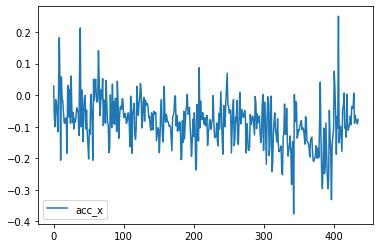

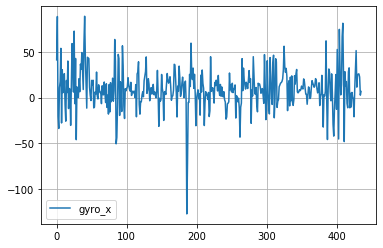

In [15]:
#visualising data
p = pose1
p.plot(use_index=True, y = "acc_x")
p.plot(use_index=True, y = "gyro_x", grid = True)

### 1.Low passfilter - useful human motion usually lies below 10 Hz

In [73]:
from scipy.signal import butter, lfilter, sosfilt
import matplotlib.pyplot as plt

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def plot_butterworth_filter(pose):
    string = 'gyro_x,gyro_y,gyro_z,acc_x,acc_y,acc_z'
    filter_list = string.split(',')
    pose_filter = pose[['time','pose']]
    pose_filter    
    
    fs = sample_rate
    lowcut = lc
    highcut = hc

    for i in filter_list:
        x = pose[i]
        
        t = pose[['time']]
        
        plt.figure()
        #x.plot(x = t, y = i)
        plt.plot(t, x, label='Raw signal (%g Hz)')
        filtered_x = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)

        plt.plot(t, filtered_x, label='Filtered signal (%g Hz)')
        plt.xlabel('samples')
        #plt.hlines([-a, a], 0, T, linestyles='--')
        plt.grid(True)
        plt.axis('tight')


def noise_filtering(pose):
    string = 'gyro_x,gyro_y,gyro_z,acc_x,acc_y,acc_z'
    filter_list = string.split(',')
    pose_filter = pose[['time','pose']]
    pose_filter

    
    fs = sample_rate
    lowcut = lc
    highcut = hc

    for i in filter_list:
        x = pose[i]
        
        #t = pose[['time']]
        
        #plt.figure()
        #x.plot(use_index=True, y = i)
        filtered_x = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)

        #plt.plot(t, filtered_x, label='Filtered signal (%g Hz)')
        #plt.xlabel('samples')
        #plt.hlines([-a, a], 0, T, linestyles='--')
        #plt.grid(True)
        #plt.axis('tight')
        
        pose_filter[i] = filtered_x

    return pose_filter

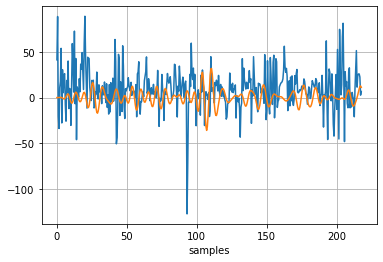

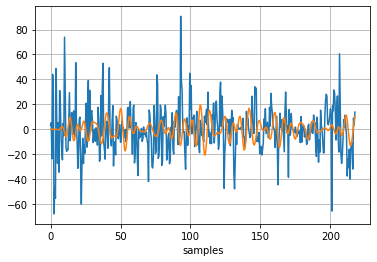

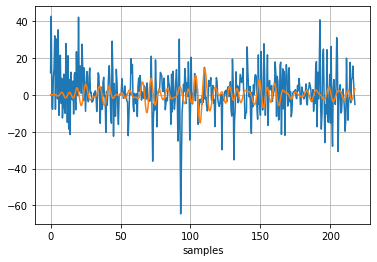

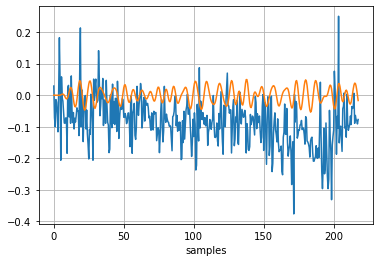

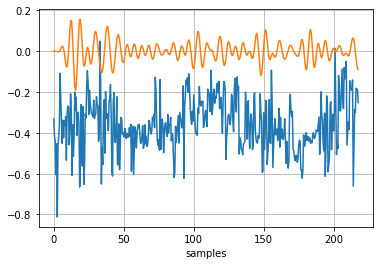

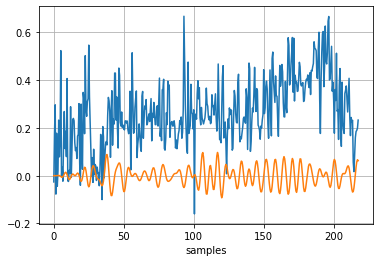

In [74]:
plot_butterworth_filter(pose1)

In [75]:
filtered_pose1 = noise_filtering(pose1)
filtered_pose2 = noise_filtering(pose2)
filtered_pose3 = noise_filtering(pose3)

/var/folders/st/k8wwkd_s68g2vnl25tz040lh0000gn/T/ipykernel_2995/4138764837.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pose_filter[i] = filtered_x
/var/folders/st/k8wwkd_s68g2vnl25tz040lh0000gn/T/ipykernel_2995/4138764837.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pose_filter[i] = filtered_x
/var/folders/st/k8wwkd_s68g2vnl25tz040lh0000gn/T/ipykernel_2995/4138764837.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [76]:
#moving average ( n, pose)

#def moving_average(window):
def moving_average(pose, N):

    A = 0
    B = A + (N * sample_rate) #sliding window length in seconds

    moving_avg = []
    for _ in range(B-A-1):
        moving_avg.append([0,0,0,0,0,0,])
    while (B <= len(pose)):

        #print(A, B)
        columns = pose.iloc[A:B][['gyro_x', 'gyro_y', 'gyro_z', 'acc_x', 'acc_y','acc_z']]
        mean_window = np.mean(columns.to_numpy(),axis = 0)

        
        moving_avg.append(mean_window)

        
        A += 1
        B = A + (N * sample_rate)
    
    return np.array(moving_avg)



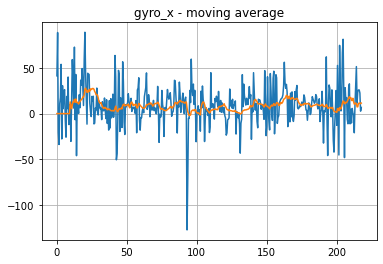

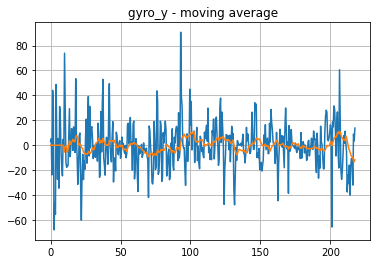

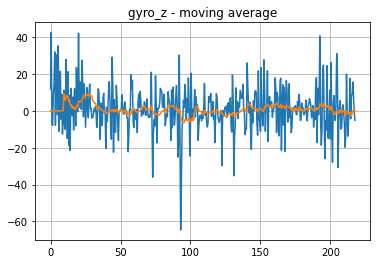

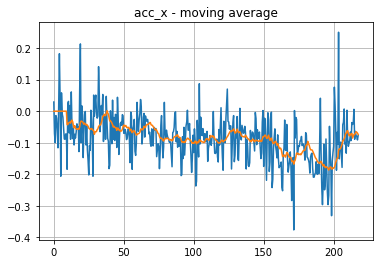

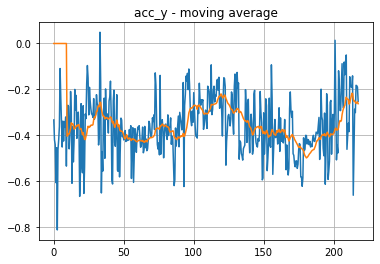

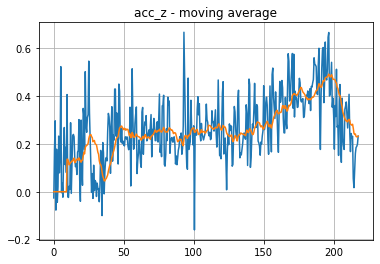

In [77]:
dic_measurements = {0: "gyro_x", 1: "gyro_y", 2: "gyro_z", 3: "acc_x", 4: "acc_y", 5: "acc_z"}
moving_array1 = moving_average(pose1,10)
moving_array2 = moving_average(pose2,10)
moving_array3 = moving_average(pose3,10)

for key,value in dic_measurements.items():
    filtered_pose1[value] = moving_array1[:,key]
    filtered_pose2[value] = moving_array2[:,key]
    filtered_pose3[value] = moving_array3[:,key]
    t = pose1[['time']]
    x = pose1[[value]]

    plt.figure()
    plt.title(value + " - moving average")
    plt.plot(t, x, label='Raw signal (%g Hz)')
    plt.grid()
    plt.plot(t, moving_array1[:,key], label='moving average signal (%g Hz)')

In [78]:
len(pose3)

221

In [79]:
pose1

,pose,gyro_x,gyro_y,gyro_z,acc_x,acc_y,acc_z,time
0,1.0,41.153,3.052,11.940,0.029,-0.333,-0.026,0.0
1,1.0,88.341,5.265,42.595,-0.071,-0.420,0.176,0.5
2,1.0,-20.248,-23.766,-6.745,-0.100,-0.440,0.297,1.0
3,1.0,-33.669,44.097,-7.827,-0.014,-0.606,-0.077,1.5
4,1.0,10.719,30.471,9.629,-0.022,-0.454,0.178,2.0
...,...,...,...,...,...,...,...,...
431,1.0,25.772,-11.787,9.034,-0.064,-0.301,0.160,215.5
432,1.0,25.749,-31.975,15.587,-0.077,-0.182,0.185,216.0
433,1.0,22.408,8.926,7.858,-0.080,-0.184,0.190,216.5
434,1.0,2.655,3.410,-0.168,-0.091,-0.190,0.199,217.0


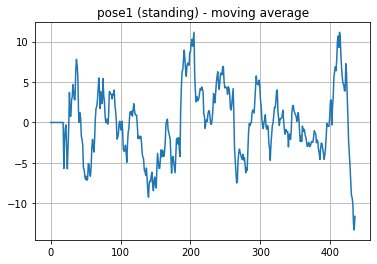

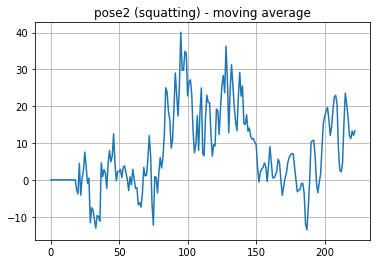

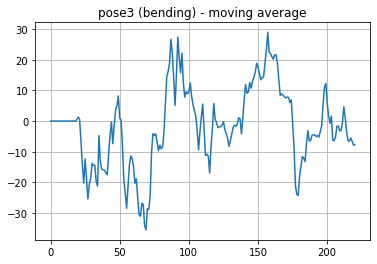

In [80]:
value = "gyro_y"

t1 = filtered_pose1.index
x1 = filtered_pose1[[value]]
t2 = filtered_pose2.index - filtered_pose2.index[0]
x2 = filtered_pose2[[value]]
t3 = filtered_pose3.index - filtered_pose3.index[0]
x3 = filtered_pose3[[value]]


plt.figure()
plt.grid()
plt.title("pose1 (standing) - moving average")
plt.plot(t1, x1, label='Raw signal (%g Hz)')

plt.figure()
plt.grid()
plt.title("pose2 (squatting) - moving average")
plt.plot(t2, x2, label='Raw signal (%g Hz)')

plt.figure()
plt.grid()
plt.title("pose3 (bending) - moving average")
plt.plot(t3, x3, label='Raw signal (%g Hz)')

### 2. do not normalise the data

### 3. apply sliding windows with 50% overlapping and the size of 4 seconds (equivalent 512 samples at 128 Hz, see Section 5 later for the details) to segment strain signals, and reshaped the one dimensional time series data into a 16×32 = 512 sample two-dimensional matrix

In [81]:
#need to cut the data into chunks of 4 seconds every 2 seconds

In [82]:
#get the rows, and convert the data into a 2D array. and store into 1 big table

In [83]:
def new_sliding_window_into_df(pose, N):

    A = 0
    B = A + (N * sample_rate) #sliding window length in seconds
    
    dataset = pd.DataFrame()
    while (B <= len(pose)):

        columns = pose.iloc[A:B][['gyro_x', 'gyro_y', 'gyro_z', 'acc_x', 'acc_y','acc_z']]
        array = columns.to_numpy().flatten()
        dataset = dataset.append({'pose' : pose['pose'].iloc[0], 'data' : [array]}, ignore_index = True)
        
        A += int(overlap * N * sample_rate)
        B = A + (N * sample_rate)
    
    return dataset

In [84]:
dataset_1 = new_sliding_window_into_df(filtered_pose1, 4)
dataset_2 = new_sliding_window_into_df(filtered_pose2, 4)
dataset_3 = new_sliding_window_into_df(filtered_pose3, 4)

/var/folders/st/k8wwkd_s68g2vnl25tz040lh0000gn/T/ipykernel_2995/3409492725.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append({'pose' : pose['pose'].iloc[0], 'data' : [array]}, ignore_index = True)
/var/folders/st/k8wwkd_s68g2vnl25tz040lh0000gn/T/ipykernel_2995/3409492725.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append({'pose' : pose['pose'].iloc[0], 'data' : [array]}, ignore_index = True)
/var/folders/st/k8wwkd_s68g2vnl25tz040lh0000gn/T/ipykernel_2995/3409492725.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append({'pose' : pose['pose'].iloc[0], 'data' : [array]}, ignore_index = True)
/var/folders/st/k8wwkd_s68g2vnl25tz040lh0000gn/T/ipykernel

In [85]:
dataset_3.head(5)

,pose,data
0,3.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,3.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,3.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,3.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,3.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [86]:
combined_df = pd.concat([dataset_1, dataset_2, dataset_3])
combined_df.reset_index(drop= True, inplace = True)

In [87]:
combined_df.head(5)

,pose,data
0,1.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,1.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,1.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,1.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


# Perform SVM

In [88]:
np.shape(combined_df["data"].iloc[0][0])

(48,)

Shape of data is 205,1

In [89]:
print(combined_df.head(5))
Y = combined_df['pose']
x = combined_df['data']

   pose                                               data
0   1.0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1   1.0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2   1.0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3   1.0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
4   1.0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...


In [90]:
#randomise and split training/testing
import random
N = len(combined_df)

N_list = list(range(N))
random.shuffle(N_list)
#print(N_list)

training_list = N_list[:int(0.8 * N)]
testing_list = N_list[int(0.8 * N):]

print(training_list)
print(testing_list)


[50, 324, 137, 31, 387, 183, 359, 19, 412, 274, 11, 278, 266, 195, 327, 276, 24, 53, 149, 365, 27, 63, 308, 353, 361, 233, 340, 291, 267, 203, 245, 356, 400, 78, 106, 179, 64, 132, 244, 72, 306, 145, 262, 25, 38, 362, 360, 380, 226, 139, 315, 59, 242, 141, 175, 82, 219, 97, 44, 326, 309, 351, 333, 283, 236, 290, 8, 304, 30, 397, 403, 298, 394, 138, 128, 46, 42, 383, 3, 110, 206, 279, 136, 231, 328, 261, 406, 241, 61, 166, 159, 169, 124, 95, 48, 281, 419, 223, 54, 405, 79, 108, 122, 378, 277, 99, 311, 177, 292, 392, 316, 52, 131, 152, 371, 318, 1, 40, 126, 229, 77, 123, 386, 193, 127, 399, 89, 85, 5, 234, 214, 295, 426, 68, 161, 134, 12, 350, 254, 339, 341, 213, 146, 18, 401, 67, 197, 162, 384, 416, 358, 385, 181, 174, 96, 155, 143, 20, 320, 407, 251, 153, 133, 209, 225, 335, 173, 415, 98, 156, 135, 284, 250, 413, 289, 81, 74, 129, 212, 393, 288, 334, 147, 305, 14, 338, 80, 272, 43, 221, 282, 114, 422, 201, 377, 204, 260, 0, 321, 112, 151, 408, 414, 70, 100, 170, 417, 348, 314, 303, 117

In [91]:
training_dataset = combined_df.iloc[training_list]
testing_dataset = combined_df.iloc[testing_list]
training_dataset.head(5)

,pose,data
50,1.0,"[[8.796249999999999, -0.6829000000000008, 0.04..."
324,3.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
137,1.0,"[[5.091500000000001, -4.57225, 0.4852, -0.0761..."
31,1.0,"[[11.232699999999998, -3.66425, 4.720249999999..."
387,3.0,"[[21.37875, -5.5914, -8.037099999999999, 0.280..."


In [92]:
training_dataset = training_dataset.reset_index()
testing_dataset = testing_dataset.reset_index()

In [93]:
testing_dataset

,index,pose,data
0,73,1.0,"[[8.987999999999998, -7.692749999999999, -0.44..."
1,258,2.0,"[[21.1741, 18.50555, -19.830150000000003, 0.00..."
2,88,1.0,"[[14.4851, -4.8972999999999995, 2.822650000000..."
3,420,3.0,"[[16.149299999999997, -5.1931999999999965, 6.4..."
4,187,1.0,"[[8.94665, -2.4453, 1.0263500000000003, -0.147..."
...,...,...,...
81,165,1.0,"[[16.215250000000005, 0.54805, 1.37485, -0.139..."
82,119,1.0,"[[9.6775, 5.70765, 0.5115000000000001, -0.0988..."
83,125,1.0,"[[3.0185, 4.4387000000000025, -2.7768000000000..."
84,120,1.0,"[[8.369399999999999, 4.933650000000001, -0.694..."


In [94]:
Y_train = training_dataset["pose"].to_list()
Y_test = testing_dataset["pose"].to_list()
x_train = [x[0] for x in training_dataset["data"].to_list()]
x_test = [x[0] for x in testing_dataset["data"].to_list()]
index_train = training_dataset["index"].to_list()
index_test = testing_dataset["index"].to_list()

for i in [Y_train, Y_test, x_train, x_test]:
    print(len(i))

344
86
344
86


In [95]:
print([len(x) for x in x_train]) #check size of data

[48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48,

In [96]:
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report, confusion_matrix
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier

def generate_results(model, xTrain, yTrain, xTest, yTest):
    num_dec_point = 3
    #train_flag = True

    # generate predictions
    y_pred = model.predict(xTest)
    y_train_pred = model.predict(xTrain) 
    print('Model Training accuracy is: ', accuracy_score(yTrain, y_train_pred))

    # calculate testing accuracy
    accuracy = accuracy_score(yTest, y_pred)
    print('Model Testing accuracy is: ', accuracy)

    p_mic, r_mic, f1_mic, _ = precision_recall_fscore_support(yTest, 
                            y_pred,
                            average='micro',
                            warn_for=())
    p_mac, r_mac, f1_mac, _ = precision_recall_fscore_support(yTest, 
                        y_pred,
                        average='macro',
                        warn_for=())
    print('micro acc,prec,rec,f1: ',round(accuracy,num_dec_point), round(p_mic,num_dec_point), round(r_mic,num_dec_point), round(f1_mic,num_dec_point),sep="\t")
    print('macro prec,rec,f1: ',round(p_mac,num_dec_point), round(r_mac,num_dec_point), round(f1_mac,num_dec_point),sep="\t")
    print('Confusion Matrix is:\n', confusion_matrix(yTest, y_pred))

In [97]:
model = SVC(kernel='linear')
model.fit(x_train,Y_train)
generate_results(model, x_train, Y_train, x_test, Y_test)

Model Training accuracy is:  0.9709302325581395
Model Testing accuracy is:  0.8604651162790697
micro acc,prec,rec,f1: 	0.86	0.86	0.86	0.86
macro prec,rec,f1: 	0.91	0.825	0.851
Confusion Matrix is:
 [[42  0  0]
 [ 9 15  0]
 [ 2  1 17]]


In [98]:
model = SVC(kernel='rbf', C = 1, probability = True, gamma = 'scale')
model.fit(x_train,Y_train)
generate_results(model, x_train, Y_train, x_test, Y_test)

Model Training accuracy is:  0.8372093023255814
Model Testing accuracy is:  0.7325581395348837
micro acc,prec,rec,f1: 	0.733	0.733	0.733	0.733
macro prec,rec,f1: 	0.763	0.656	0.678
Confusion Matrix is:
 [[41  0  1]
 [10 13  1]
 [ 7  4  9]]


In [99]:
model = SVC(kernel='poly', degree = 6, C = 1, probability = True, gamma = 'scale')
model.fit(x_train,Y_train)
generate_results(model, x_train, Y_train, x_test, Y_test)

Model Training accuracy is:  0.8343023255813954
Model Testing accuracy is:  0.686046511627907
micro acc,prec,rec,f1: 	0.686	0.686	0.686	0.686
macro prec,rec,f1: 	0.751	0.603	0.618
Confusion Matrix is:
 [[41  0  1]
 [13  8  3]
 [ 9  1 10]]


In [100]:
model = tree.DecisionTreeClassifier()
model.fit(x_train,Y_train)
generate_results(model, x_train, Y_train, x_test, Y_test)

Model Training accuracy is:  0.9767441860465116
Model Testing accuracy is:  0.8604651162790697
micro acc,prec,rec,f1: 	0.86	0.86	0.86	0.86
macro prec,rec,f1: 	0.866	0.84	0.846
Confusion Matrix is:
 [[40  2  0]
 [ 5 16  3]
 [ 2  0 18]]


In [101]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(x_train,Y_train)
generate_results(model, x_train, Y_train, x_test, Y_test)

Model Training accuracy is:  0.8459302325581395
Model Testing accuracy is:  0.7093023255813954
micro acc,prec,rec,f1: 	0.709	0.709	0.709	0.709
macro prec,rec,f1: 	0.762	0.642	0.649
Confusion Matrix is:
 [[40  0  2]
 [ 8  9  7]
 [ 8  0 12]]


In [102]:
error

NameError: name 'error' is not defined

In [103]:
#https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65
def tanh(x):
    return np.tanh(x);

def tanh_prime(x):
    return 1-np.tanh(x)**2;

def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2));

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;

In [104]:
#https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward_propagation(self, input):
        raise NotImplementedError

    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError

In [105]:
#https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65
class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error

In [106]:
#https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65

class FCLayer(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5

    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)

        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

In [107]:
##https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    def add(self, layer):
        self.layers.append(layer)

    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    def predict(self, input_data):
        samples = len(input_data)
        result = []

        for i in range(samples):
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return result

    def fit(self, x_train, y_train, epochs, learning_rate):
        samples = len(x_train)

        for i in range(epochs):
            err = 0
            for j in range(samples):
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                err += self.loss(y_train[j], output)
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)

            err /= samples
            print('epoch %d/%d   error=%f' % (i+1, epochs, err))

In [108]:
np.shape(x_train[0]) #shape of x

(48,)

In [109]:
len(Y_train)

344

In [110]:
from keras.utils import np_utils

In [111]:
def one_hot_vector(Y_train):
    temp = []
    for i in Y_train:
        if i == 1:
            temp.append([1,0,0])
        elif i == 2:
            temp.append([0,1,0])
        elif i == 3:
            temp.append([0,0,1])
    return np.array(temp)
        

In [112]:
np.shape(one_hot_vector(Y_train))

(344, 3)

In [113]:
#https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65

from keras.utils import np_utils

Y_train = one_hot_vector(Y_train) #np_utils.to_categorical(Y_train)
Y_test = one_hot_vector(Y_test) #np_utils.to_categorical(Y_test)

#print(np.shape(x_train[0].reshape(1,-1)))

#x_train[0].T
x_train = [i.reshape(1,-1) for i in x_train]

In [114]:
# Network
net = Network()
net.add(FCLayer(48, 32))                # input_shape=(1, 28*28)    ;   output_shape=(1, 100)
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(32, 16))                   # input_shape=(1, 100)      ;   output_shape=(1, 50)
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(16, 3))                    # input_shape=(1, 50)       ;   output_shape=(1, 10)
net.add(ActivationLayer(tanh, tanh_prime))

net.use(mse, mse_prime)
net.fit(x_train, Y_train, epochs=300, learning_rate=0.01)

# test on 3 samples
result = net.predict(x_test)
print("\n")
print("predicted values : ")
print(result, end="\n")
print("true values : ")
print(Y_test)

epoch 1/300   error=0.314825
epoch 2/300   error=0.194889
epoch 3/300   error=0.176261
epoch 4/300   error=0.163574
epoch 5/300   error=0.156779
epoch 6/300   error=0.151021
epoch 7/300   error=0.145003
epoch 8/300   error=0.141097
epoch 9/300   error=0.136887
epoch 10/300   error=0.134113
epoch 11/300   error=0.129723
epoch 12/300   error=0.127282
epoch 13/300   error=0.124677
epoch 14/300   error=0.121679
epoch 15/300   error=0.120086
epoch 16/300   error=0.117279
epoch 17/300   error=0.115070
epoch 18/300   error=0.112411
epoch 19/300   error=0.110632
epoch 20/300   error=0.108171
epoch 21/300   error=0.105782
epoch 22/300   error=0.104692
epoch 23/300   error=0.102548
epoch 24/300   error=0.100341
epoch 25/300   error=0.099259
epoch 26/300   error=0.098126
epoch 27/300   error=0.098237
epoch 28/300   error=0.096053
epoch 29/300   error=0.095248
epoch 30/300   error=0.092844
epoch 31/300   error=0.092148
epoch 32/300   error=0.090805
epoch 33/300   error=0.089885
epoch 34/300   erro

epoch 269/300   error=0.023810
epoch 270/300   error=0.023420
epoch 271/300   error=0.023554
epoch 272/300   error=0.026358
epoch 273/300   error=0.023331
epoch 274/300   error=0.023211
epoch 275/300   error=0.023390
epoch 276/300   error=0.022898
epoch 277/300   error=0.023059
epoch 278/300   error=0.023268
epoch 279/300   error=0.023579
epoch 280/300   error=0.022885
epoch 281/300   error=0.022700
epoch 282/300   error=0.024207
epoch 283/300   error=0.025332
epoch 284/300   error=0.026922
epoch 285/300   error=0.025140
epoch 286/300   error=0.023326
epoch 287/300   error=0.025581
epoch 288/300   error=0.022582
epoch 289/300   error=0.022897
epoch 290/300   error=0.022456
epoch 291/300   error=0.022212
epoch 292/300   error=0.022370
epoch 293/300   error=0.022388
epoch 294/300   error=0.022424
epoch 295/300   error=0.022709
epoch 296/300   error=0.022395
epoch 297/300   error=0.021846
epoch 298/300   error=0.021941
epoch 299/300   error=0.022873
epoch 300/300   error=0.022105


predic

In [115]:
#testing - metrics

a = np.array([np.argmax(i)+1 for i in Y_test])
b = np.array([np.argmax(i)+1 for i in result])

print(classification_report(a, b))
print(confusion_matrix(a,b))

              precision    recall  f1-score   support

           1       0.70      0.83      0.76        42
           2       0.44      0.29      0.35        24
           3       0.55      0.55      0.55        20

    accuracy                           0.62        86
   macro avg       0.56      0.56      0.55        86
weighted avg       0.59      0.62      0.60        86

[[35  4  3]
 [11  7  6]
 [ 4  5 11]]


=========

In [116]:
'''
net = Net(n_feature=2, n_hidden=10, n_output=2)     # define the network
print(net)  # net architecture

optimizer = torch.optim.SGD(net.parameters(), lr=0.02)
loss_func = torch.nn.CrossEntropyLoss()  # the target label is NOT an one-hotted
'''

'\nnet = Net(n_feature=2, n_hidden=10, n_output=2)     # define the network\nprint(net)  # net architecture\n\noptimizer = torch.optim.SGD(net.parameters(), lr=0.02)\nloss_func = torch.nn.CrossEntropyLoss()  # the target label is NOT an one-hotted\n'

#Saving model

In [120]:
#saving the trained model

import pickle

filename = 'SVM.sav'
pickle.dump(model, open(filename, 'wb'))

In [121]:
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(x_test, Y_test)
#print(result)